In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import scipy

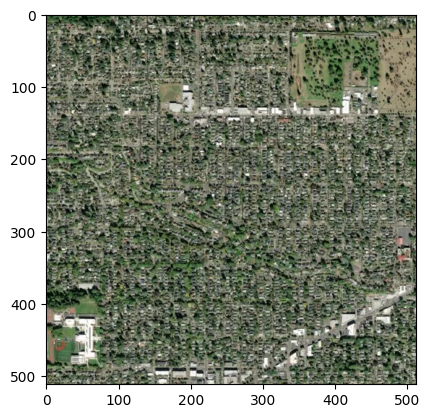

In [6]:
image = Image.open('sat_at_2611_5858_14zoom.png')
sat = np.array(image)
plt.imshow(sat)

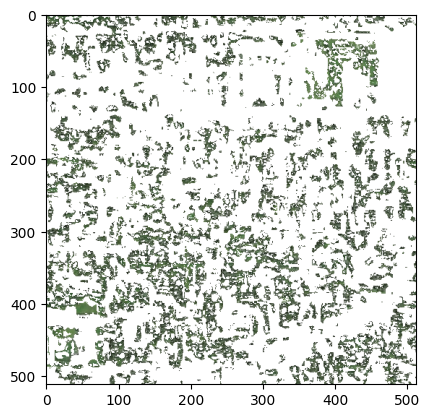

In [155]:
hsvsat = matplotlib.colors.rgb_to_hsv(sat.astype("float") / 256)
greenmask = np.ones((512,512), dtype="bool")
greenmask *= 0.25 < hsvsat[:,:,0] # Hue
greenmask *= hsvsat[:,:,0] < 0.33
greenmask *= 0.1 < hsvsat[:,:,1] # value
greenmask *= hsvsat[:,:,1] < 0.5
greenmask *= 0.1 < hsvsat[:,:,2] # saturation
greenmask *= hsvsat[:,:,2] < 0.55

greenonly = sat.copy()
greenonly[~greenmask] = [255,255,255]
plt.imshow(greenonly)
image = Image.fromarray(greenonly)
image.save("greenonly.png")

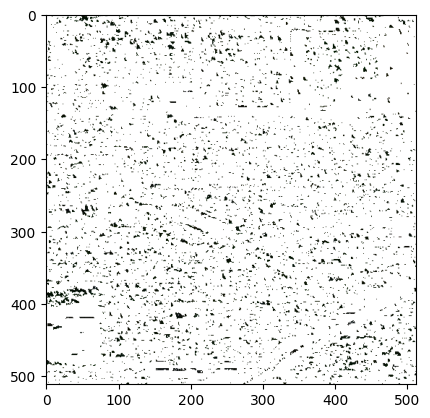

In [162]:
shadowmask = np.ones((512,512), dtype="bool")
shadowmask *= hsvsat[:,:,2] < 0.15

shadowonly = sat.copy()
shadowonly[~shadowmask] = [255,255,255]
plt.imshow(shadowonly)
image = Image.fromarray(shadowonly)
image.save("shadowonly.png")

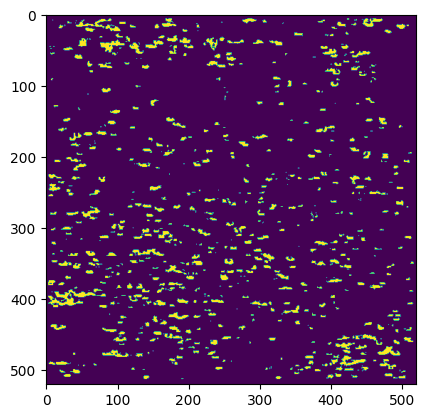

In [184]:
greenkernel = """
.........
.........
.........
..#####..
..#####..
..#####..
..#####..
.........
.........
"""
shadowkernel = """
.........
.........
.........
.........
.........
###...###
#########
#########
#########
"""

greenkernel = [[i == "#" for i in row] for row in greenkernel.split("\n")[1:-1]]
shadowkernel = [[i == "#" for i in row] for row in shadowkernel.split("\n")[1:-1]]
greenscore = scipy.signal.convolve2d(greenmask.astype("uint8"), greenkernel)
shadowscore = scipy.signal.convolve2d(shadowmask.astype("uint8"), shadowkernel)
treescore = (greenscore > 5) * (shadowscore > 5)
plt.imshow(treescore)
image = Image.fromarray(treescore)
image.save("treescore.png")

In [164]:
greenmask[0:5,:5]

array([[False, False, False, False, False],
       [False, False,  True,  True, False],
       [False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

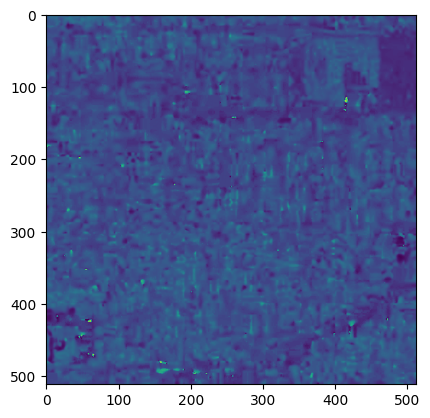

In [117]:
plt.imshow(hsvsat[:,:,0])

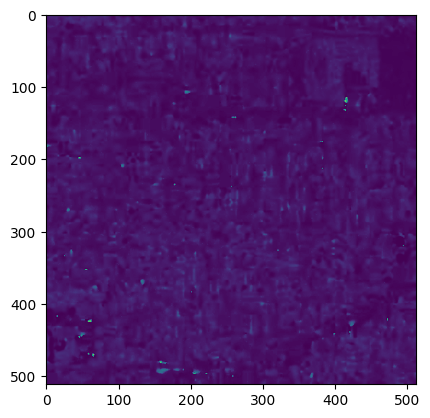

In [120]:
# ranges = [[90/360,120/360],[.2,.5],[.2,.55]]
ranges = [[0.3,0.4],[0,1],[0,1]]
centers = [(i[0] + i[1]) / 2 for i in ranges]
deviations = [ranges[i][1] - centers[i] for i in range(3)]
greenness = (hsvsat / deviations - centers)
greenness *= [1,0,0]
greenness = greenness ** 2
plt.imshow(greenness[:,:,0])
greenness = greenness.sum(axis=2)
greenness = -greenness
# plt.hist(greenness).flat)
# greenness = np.log(greenness)
greenness += 100
greenness[greenness<0] = 0
# plt.imshow(greenness)


(array([ 8560., 17786., 32347., 52431., 63753., 54062., 21942.,  6313.,
         2628.,  2322.]),
 array([  1.        ,  26.39999962,  51.79999924,  77.19999695,
        102.59999847, 128.        , 153.3999939 , 178.80000305,
        204.19999695, 229.6000061 , 255.        ]),
 <BarContainer object of 10 artists>)

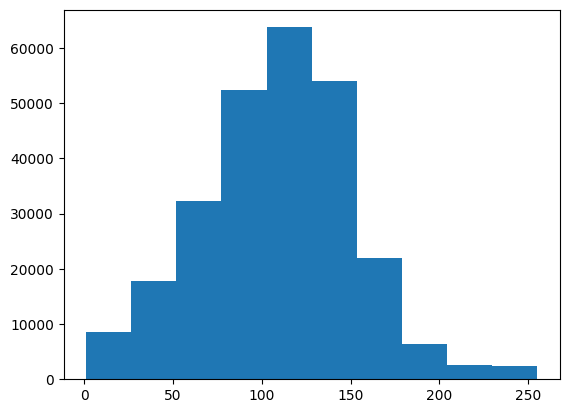

In [85]:
grayscale = hsvsat[:,:,2]
plt.hist(grayscale.flat)
#plt.imshow(shadows)

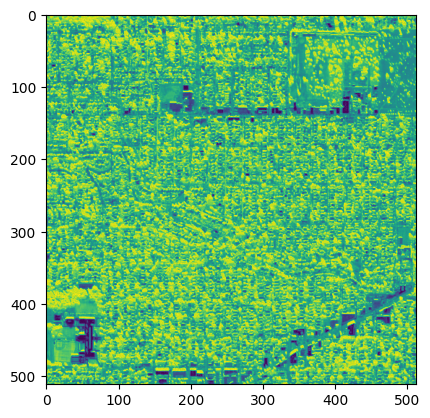

In [44]:
treecolor = [25.9,38,22]
greenness = np.sqrt(((sat.reshape((512*512,3)) - treecolor) ** 2).sum(axis=1)).reshape((512,512))
greenness /= max(greenness.flat)
greenness = 1 - greenness
plt.imshow(greenness)



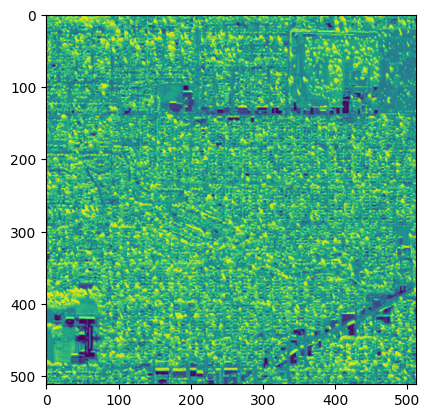

In [45]:
shadowcolor = [0, 0.0, 0]
shadowness = np.sqrt(((sat.reshape((512*512,3)) - shadowcolor) ** 2).sum(axis=1)).reshape((512,512))
shadowness /= max(shadowness.flat)
shadowness = 1 - shadowness
plt.imshow(shadowness)

[[[0.82849142 0.         0.9677977 ]
  [0.92820309 0.         0.93349789]
  [0.91975294 0.         0.94149455]
  ...
  [0.35165892 0.         0.58768149]
  [0.98023694 0.         0.92603537]
  [0.73614881 0.         0.95512569]]

 [[0.69792829 0.         0.92585343]
  [0.64394006 0.         0.89233354]
  [0.53194088 0.         0.79879714]
  ...
  [0.54998629 0.         0.81084575]
  [0.94497226 0.         0.97509207]
  [0.96345025 0.         0.95549993]]

 [[0.52283352 0.         0.78968011]
  [0.45558282 0.         0.72002861]
  [0.42708624 0.         0.68792367]
  ...
  [0.37314095 0.         0.61604842]
  [0.29817874 0.         0.5170524 ]
  [0.3930232  0.         0.64070513]]

 ...

 [[0.07493351 0.         0.15702209]
  [0.00777501 0.         0.019166  ]
  [0.26194304 0.         0.46482113]
  ...
  [0.01656298 0.         0.03907825]
  [0.0203035  0.         0.04707762]
  [0.05812021 0.         0.12432492]]

 [[0.08892258 0.         0.18332448]
  [0.03479485 0.         0.07808049]


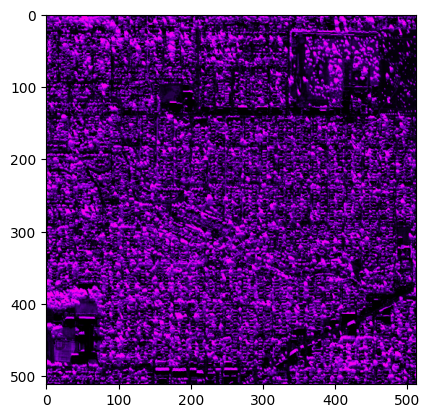

In [40]:
treeshadows = np.zeros(512 * 512 * 3)
treeshadows[0::3] = shadowness.flat
treeshadows[2::3] = greenness.flat
treeshadows = treeshadows.reshape((512,512,3))
treeshadows = treeshadows ** 10
print(treeshadows)
plt.imshow(treeshadows)
im = Image.fromarray((treeshadows * 256).astype("uint8"))
im.save("treeshadows.png")

In [ ]:
def likelyATree(sat, x, y):
    w = len(sat[0])
    h = len(sat)
    num_greens = 0;
    for xx in range(x-2, x+3):
        if (xx < 0 || xx >= w):
            continue
        for yy in range(y-2,y+3):
            if (yy < 0 || yy >= h):
                continue
            pix = sat[x,y]
            if ((pix[1] - 100 > 